In [1]:
import numpy as np
import matplotlib as plt
# Load a pair from CurveFault_A
seis = np.load("/kaggle/input/waveform-inversion/train_samples/CurveFault_A/seis2_1_0.npy")  # Shape: (500, num_sources, time_steps, num_receivers)
vel = np.load("/kaggle/input/waveform-inversion/train_samples/CurveFault_A/vel2_1_0.npy")    # Shape: (500, height, width)

print("Seismic shape:", seis.shape)
print("Velocity shape:", vel.shape)

Seismic shape: (500, 5, 1000, 70)
Velocity shape: (500, 1, 70, 70)


In [2]:
vel = vel.squeeze(1)  # New shape: (500, 70, 70)

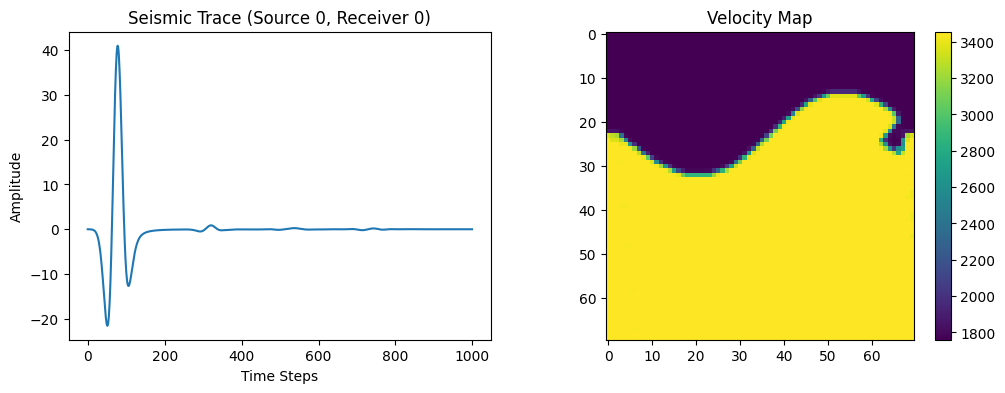

In [3]:
import matplotlib.pyplot as plt

# Plot first sample
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Seismic: First source, first receiver
ax1.plot(seis[0, 0, :, 0])
ax1.set_title("Seismic Trace (Source 0, Receiver 0)")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Amplitude")

# Velocity: First sample
ax2.imshow(vel[0], cmap="viridis")
ax2.set_title("Velocity Map")
plt.colorbar(ax2.imshow(vel[0], cmap="viridis"), ax=ax2)
plt.show()

In [4]:
import torch
import torch.nn as nn

class SeismicNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # (1000,70) -> (500,35)
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # (500,35) -> (250,17)
        )
        
        # Decoder
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # (250,17) -> (500,34)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.up2 = nn.Upsample(size=(1000,70), mode='bilinear', align_corners=False)  # Directly to (1000,70)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.up1(x)
        x = self.dec1(x)
        x = self.up2(x)
        x = self.dec2(x)
        return x


In [5]:
model = SeismicNet()
test_input = torch.randn(32, 5, 1000, 70)
output = model(test_input)
print(f"Output shape: {output.shape}")


Output shape: torch.Size([32, 1, 1000, 70])


Epoch [1/100] - Train Loss: 0.0805, Val Loss: 0.0923
Epoch [2/100] - Train Loss: 0.0791, Val Loss: 0.0912
Epoch [3/100] - Train Loss: 0.0775, Val Loss: 0.0904
Epoch [4/100] - Train Loss: 0.0777, Val Loss: 0.0899
Epoch [5/100] - Train Loss: 0.0778, Val Loss: 0.0894
Epoch [6/100] - Train Loss: 0.0755, Val Loss: 0.0891
Epoch [7/100] - Train Loss: 0.0765, Val Loss: 0.0888
Epoch [8/100] - Train Loss: 0.0759, Val Loss: 0.0886
Epoch [9/100] - Train Loss: 0.0767, Val Loss: 0.0883
Epoch [10/100] - Train Loss: 0.0760, Val Loss: 0.0881
Epoch [11/100] - Train Loss: 0.0755, Val Loss: 0.0880
Epoch [12/100] - Train Loss: 0.0748, Val Loss: 0.0879
Epoch [13/100] - Train Loss: 0.0753, Val Loss: 0.0877
Epoch [14/100] - Train Loss: 0.0752, Val Loss: 0.0875
Epoch [15/100] - Train Loss: 0.0758, Val Loss: 0.0874
Epoch [16/100] - Train Loss: 0.0743, Val Loss: 0.0870
Epoch [17/100] - Train Loss: 0.0761, Val Loss: 0.0870
Epoch [18/100] - Train Loss: 0.0750, Val Loss: 0.0867
Epoch [19/100] - Train Loss: 0.0743, 

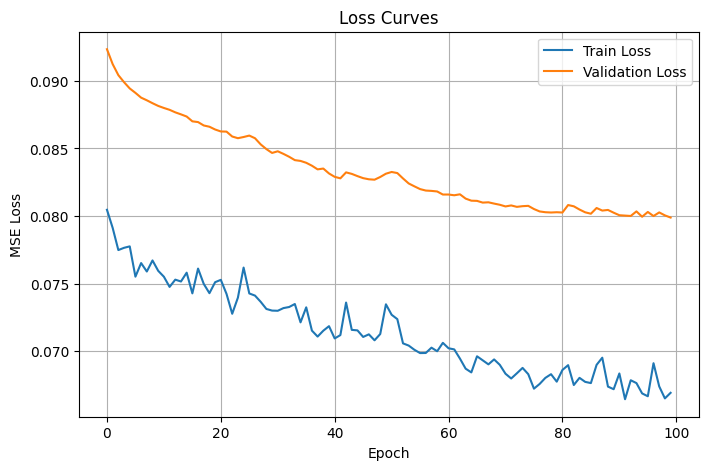

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split

# Load Data
seis = np.load("/kaggle/input/waveform-inversion/train_samples/CurveFault_A/seis2_1_0.npy")
vel = np.load("/kaggle/input/waveform-inversion/train_samples/CurveFault_A/vel2_1_0.npy")

# Normalize
seis = (seis - seis.mean()) / seis.std()
vel = (vel - vel.min()) / (vel.max() - vel.min())  # Scale to [0,1]

# Prepare Torch Datasets
seis = torch.tensor(seis, dtype=torch.float32)  # (500, 5, 1000, 70)
vel = torch.tensor(vel, dtype=torch.float32).squeeze(1)  # (500, 70, 70)

seis = seis.permute(0, 1, 2, 3)  # (500, 5, 1000, 70)
vel = vel.unsqueeze(1)           # (500, 1, 70, 70)

dataset = TensorDataset(seis, vel)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
class SeismicNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, stride=2, padding=1),  # stride=2 instead of MaxPool
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.dec1(x)
        x = self.dec2(x)
        return x


model = SeismicNet().to(device)

# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training
epochs = 100
train_losses = []
val_losses_all = []

for epoch in range(epochs):
    model.train()
    epoch_losses = []

    for batch_seis, batch_vel in train_loader:
        batch_seis = batch_seis.to(device)
        batch_vel = batch_vel.to(device)
        
        outputs = model(batch_seis)

        # Crop outputs
        outputs = outputs[:, :, -70:, :70]  # ✂️ Crop to [batch, 1, 70, 70]

        loss = criterion(outputs, batch_vel)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    train_loss = np.mean(epoch_losses)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_epoch_losses = []

    with torch.no_grad():
        for batch_seis, batch_vel in val_loader:
            batch_seis = batch_seis.to(device)
            batch_vel = batch_vel.to(device)

            outputs = model(batch_seis)
            outputs = outputs[:, :, -70:, :70]  # ✂️ Crop here too

            val_loss = criterion(outputs, batch_vel)
            val_epoch_losses.append(val_loss.item())

    val_loss_mean = np.mean(val_epoch_losses)
    val_losses_all.append(val_loss_mean)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss_mean:.4f}")

# Plot Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses_all, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()


📊 What this Loss Curve shows:
Both Train and Validation losses are decreasing → ✅ Good sign.

Training loss is going down steadily → ✅ Model is learning.

Validation loss is also decreasing → ✅ No overfitting yet.

After about epoch 60, validation loss flattens → ⏳ Learning is slowing.

Small wiggles (noise) in the loss curve are normal at this stage → training is very stable overall.